In [1]:
import gym, pickle, numpy as np, matplotlib.pyplot as plt
import tttenv

BOARD_ROWS,BOARD_COLS = 3,3
TOTAL_BOARD_SPACES = BOARD_ROWS*BOARD_COLS
COORD_TO_INDEX = lambda x : (x[0] * BOARD_ROWS) + x[1]

In [3]:
import sys,os
from datetime import datetime

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
currentdir = os.path.abspath(os.getcwd())
currenttime = datetime.now()
timetext = str(currenttime.year) + '-' + str(currenttime.month) + '-' + str(currenttime.day)

In [4]:
# Super class for players (both human and agent)
class Player:
    def __init__(self, name):
        self.name = name
        
    def chooseAction(self, positions, currentBoard=None):
        pass
        
    def addState(self, state):
        pass
    
    def feedReward(self, reward):
        pass
    
    def reset(self):
        pass

In [5]:
# Class that defines agent players
# Two of these players will be learning and playing with each other
class QAgentPlayer:
    def __init__(self, name, turn, explRate=.3):
        self.name = name
        self.turn = turn
        # Implement epsilon-greedy method of selecting actions
        # Default .3 value means 30% of time agent takes random action, 70% of time agent takes greedy action
        self.explRate = explRate
        # Record all positions taken
        self.states = []
        # Learning rate 
        self.lr = .2
        self.decayGamma = .9
        # State -> Value
        self.statesValue = {}
        
    # Get a unique hash value that corresponds with the given board state
    def getHash(self, board):
        return str(board.reshape(BOARD_ROWS * BOARD_COLS))
    
    # Using this abstraction because HumanPlayer class will have this as well
    def addState(self, state):
        self.states.append(state)
        
    def chooseAction(self, openPositions, currentBoard):
        if np.random.uniform(0,1) <= self.explRate:
            # Take random action
            index = np.random.choice(len(openPositions))
            action = openPositions[index]
        else:
            maxValue = -999
            for p in openPositions:
                nextBoard = currentBoard.copy()
                nextBoard[p] = self.turn
                nextBoardHash = self.getHash(nextBoard)
                value = 0 if self.statesValue.get(nextBoardHash) is None else self.statesValue.get(nextBoardHash)
                if value > maxValue:
                    maxValue = value
                    action = p
        return action
    
    # At the end of the game, backpropogate and update state values
    # The updated value of state t equals the current value of state t
    #   adding the difference between the value of next state and the value of current state,
    #   which is multiplied by a learning rate α (Given the reward of intermediate state is 0)
    def feedReward(self, reward):
        for state in (reversed(self.states)):
            if self.statesValue.get(state) is None:
                self.statesValue[state] = 0
            self.statesValue[state] += self.lr * (self.decayGamma * reward - self.statesValue[state])
            reward = self.statesValue[state]
    
    # For when there's a new round
    def reset(self):
        self.states = []

    # After training, an agent has its policy stored in self.stateValues
    # This can be saved to play against a human player
    def savePolicy(self):
        with open(currentdir + '/policies/ttt_policy_' + str(self.name), 'wb') as fw:
            pickle.dump(self.statesValue, fw)

    # Loading the policy when playing a human
    def loadPolicy(self, file):
        with open(file, 'rb') as fr:
            self.statesValue = pickle.load(fr)

In [6]:
# Class that inherits most of QAgent player
# Implements deep learning instead of Q-learning
class DeepAgentPlayer(QAgentPlayer):
    def __init__(self, name, turn, explRate=.3):
        super(DeepAgentPlayer, self, name, turn, explRate).__init__()
        
    def loadModel(self):
        s = 'model_values' + self.tag + '.h5'
        model_file = Path(s)
        if model_file.is_file():
            model = Km.load_model(s)
        else:
            model = Km.Sequential()
            model.add(Kl.Dense(18, activation='relu', input_dim=9))
            model.add(Kl.Dense(18, activation='relu'))
            model.add(Kl.Dense(1, activation='linear'))
            model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['accuracy'])

        model.summary()
        return model

In [7]:
# Class for human player
# Mostly inherited from super class Player
class HumanPlayer(Player):    
    def chooseAction(self, positions, currentBoard=None):
        while True:
            try:
                i = int(input("Input action row-> "))
                j = int(input("Input action column-> "))
            except ValueError:
                continue
            if (i, j) in positions:
                return (i, j)

In [8]:
# Find vacant positions after a turn is made
def availablePositions(board):
    positions = []
    for i in range(BOARD_ROWS):
        for j in range(BOARD_COLS):
            if board[i,j] == 0:
                # Coordinates need to be in tuple form
                positions.append((i,j))
    return positions

def startGame(p1, p2, env, learn=True):
    gameOver = False
    human = p1.name == "human" or p2.name == "human"
    observation = np.zeros((BOARD_ROWS, BOARD_COLS))
    while not gameOver:
        # Player 1
        openPositions = availablePositions(observation)
        observation,reward,gameOver,actionHash = env.step(p1.chooseAction(openPositions, observation))
        p1.addState(actionHash)
        # When there's a human player, print out stuff
        if human:
            env.render()
        if gameOver:
            if human and reward[0] == 1:
                print(f"{p1.name} wins!")
            elif human:
                print("tie!")
            if learn:
                p1.feedReward(reward[0])
                p2.feedReward(reward[1])
            break
        # Player 2
        openPositions = availablePositions(observation)
        observation,reward,gameOver,actionHash = env.step(p2.chooseAction(openPositions, observation))
        p2.addState(actionHash)
        if human:
            env.render()
        if gameOver:
            if human:
                print(f"{p2.name} wins!")
            if learn:
                p1.feedReward(reward[0])
                p2.feedReward(reward[1])
            break
    env.reset()
    p1.reset()
    p2.reset()
    return 1 if reward[0] == 1 else (2 if reward[1] == 1 else 0)

In [9]:
# Analysis of agent performance
env = gym.make('tttenv-v0')
p1Results = [[], []]
p2Results = [[], []]
ties = [[], []]
count = 0
for exp in range(1, 19):
    print('...', end='\r')
    i = 2 ** exp
    p1 = QAgentPlayer("p1", 1)
    p2 = QAgentPlayer("p2", -1)
    for _ in range(i):
        startGame(p1, p2, env)
    # Test agents
    p1.explRate = 0
    p2.explRate = 0
    # x-axis is games played
    # y-axis is games won/tied
    p1Results[0].append(i)
    p1Results[1].append(0)
    p2Results[0].append(i)
    p2Results[1].append(0)
    ties[0].append(i)
    ties[1].append(0)
    for _ in range(100):
        result = startGame(p1, p2, env, False)
        if result == 0:
            ties[1][count] += 1
        elif result == 1:
            p1Results[1][count] += 1
        elif result == 2:
            p2Results[1][count] += 1
    count += 1
    print(f'finished training and testing for {i} games...')
print(f'saving results in file graph_{timetext} ...')
# Save results
with open(currentdir + '/graphingData/graph_' + timetext, 'wb') as f:
    pickle.dump((p1Results, p2Results, ties), f)

finished training and testing for 2 games...
finished training and testing for 4 games...
finished training and testing for 8 games...
finished training and testing for 16 games...
finished training and testing for 32 games...
finished training and testing for 64 games...
finished training and testing for 128 games...
finished training and testing for 256 games...
finished training and testing for 512 games...
finished training and testing for 1024 games...
finished training and testing for 2048 games...
finished training and testing for 4096 games...
finished training and testing for 8192 games...
finished training and testing for 16384 games...
finished training and testing for 32768 games...
finished training and testing for 65536 games...
finished training and testing for 131072 games...
finished training and testing for 262144 games...
saving results in file graph_2020-3-17 ...


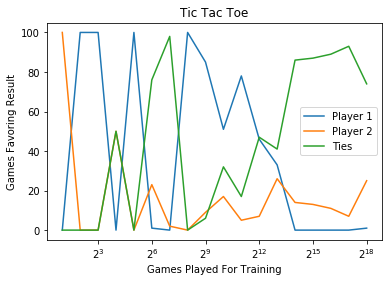

In [10]:
# Graph results
plt.semilogx(p1Results[0], p1Results[1], label='Player 1', basex=2)
plt.semilogx(p2Results[0], p2Results[1], label='Player 2', basex=2)
plt.semilogx(ties[0], ties[1], label='Ties', basex=2)
plt.xlabel('Games Played For Training') 
plt.ylabel('Games Favoring Result') 
plt.title('Tic Tac Toe') 
plt.legend()
plt.show() 

In [11]:
# Train agents
p1 = QAgentPlayer("p1", 1)
p2 = QAgentPlayer("p2", -1)
env = gym.make('tttenv-v0')
print("training...")
for _ in range(1000):
    startGame(p1, p2, env)
# Save Results
p1.savePolicy()
print("saved p1 policy")
p2.savePolicy()
print("saved p2 policy")

training...
saved p1 policy
saved p2 policy


In [ ]:
# Human play with trained p1
# Make sure Agent isn't training anymore
p1 = QAgentPlayer("computer", 1, explRate=0)
p1.loadPolicy(currentdir + "/policies/ttt_policy_p1")
p2 = HumanPlayer("human")
startGame(p1, p2, env)

In [ ]:
# Human play with trained p2
# Make sure Agent isn't training anymore
p1 = HumanPlayer("human")
p2 = QAgentPlayer("computer", -1, explRate=0)
p2.loadPolicy(currentdir + "/policies/ttt_policy_p2")
startGame(p1, p2, env)